In [40]:
# Importing libraries
import os 
import pandas as pd 
import numpy as np
import sys
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yaml 

In [42]:
#Importing directories
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.config import RAW_DATA_DIR, PROCESSED_DATA_DIR, BASE_DIR
from src.exception import STOCKPULSEEXCEPTION
from src.log_handler import LOGGER

with open(os.path.join(BASE_DIR, "config/config.yaml"), "r") as file:
    SETTINGS= yaml.safe_load(file)


In [3]:
#Loading the dataframe
stock_data= pd.read_csv(os.path.join(RAW_DATA_DIR, f'{datetime.now().strftime("%Y-%m-%d")}_raw_data.csv'))

In [4]:
# Having a look at top 5 values of dataframe
stock_data.head()

,datetime,open,high,low,close,volume
0,2025-09-05 15:08:00,1243.380,1243.38,1243.330,1243.33,94
1,2025-09-05 15:07:00,1243.420,1243.51,1243.420,1243.51,292
2,2025-09-05 15:06:00,1243.320,1243.88,1243.320,1243.50,110
3,2025-09-05 15:05:00,1242.665,1242.99,1242.665,1242.88,214
4,2025-09-05 15:04:00,1242.655,1242.78,1242.610,1242.69,260


In [5]:
# Looking at the bottom 5 values of the dataframe
stock_data.tail()

,datetime,open,high,low,close,volume
4995,2025-08-18 14:48:00,1246.51501,1246.51501,1246.19495,1246.35535,2085
4996,2025-08-18 14:47:00,1246.52002,1246.96997,1246.00745,1246.00745,2640
4997,2025-08-18 14:46:00,1245.72998,1245.79504,1245.72998,1245.79504,1875
4998,2025-08-18 14:45:00,1246.06995,1246.08997,1245.92004,1245.92505,3204
4999,2025-08-18 14:44:00,1246.19995,1246.19995,1246.15503,1246.15503,2105


In [6]:
# Information about the dataset 
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  5000 non-null   object 
 1   open      5000 non-null   float64
 2   high      5000 non-null   float64
 3   low       5000 non-null   float64
 4   close     5000 non-null   float64
 5   volume    5000 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 234.5+ KB


In [7]:
#Changing the datatype 
stock_data['datetime'] = pd.to_datetime(stock_data['datetime'])

In [10]:
# Checking for null values of the volume
stock_data.isnull().sum()

datetime    0
open        0
high        0
low         0
close       0
volume      0
dtype: int64

In [9]:
# AS data is lively taken so it is better to make a assumption that ki sometime there can be chances of null values so let deal with it
# even if it is clean now.

for column, value in stock_data.isnull().sum().squeeze().to_dict().items():
    if value >0:
        if stock_data[column].dtype in ['float64', 'int64']:
            stock_data[column] = stock_data[column].fillna(method="ffill")
            stock_data[column] = stock_data[column].fillna(method='bfill')

            if stock_data[column].isnull().sum() >0:
                stock_data[column] = stock_data[column].fillna(stock_data[column].median())

        else:
            stock_data[column] = stock_data[column].fillna(stock_data[column].mode()[0])


In [13]:
# Checking for update date data type
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  5000 non-null   datetime64[ns]
 1   open      5000 non-null   float64       
 2   high      5000 non-null   float64       
 3   low       5000 non-null   float64       
 4   close     5000 non-null   float64       
 5   volume    5000 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 234.5 KB


In [ ]:
# Checking for the presence of duplicated data in dataframe
stock_data.duplicated().sum()

np.False_

In [21]:
# AS data is lively taken so it is better to make a assumption that ki sometime there can be chances of duplicated values so let deal with it
# even if it is clean now.
if stock_data.duplicated().sum()>0:
    stock_data= stock_data.drop_duplicates()

In [28]:
# Renaming the column 
stock_data = stock_data.rename(columns={'datetime':"ds", "close": "y"})


<Axes: ylabel='y'>

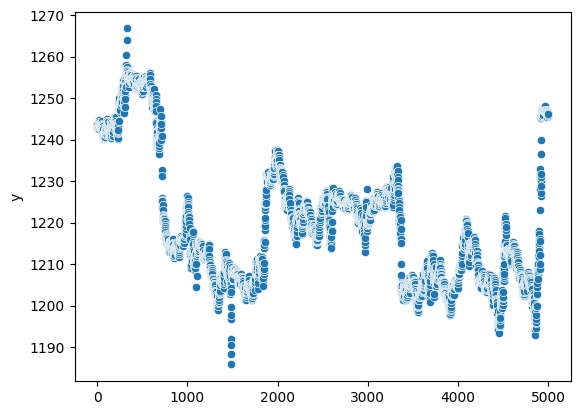

In [39]:
# Checking for the outlier in the target variable 
sns.scatterplot(stock_data['y'])


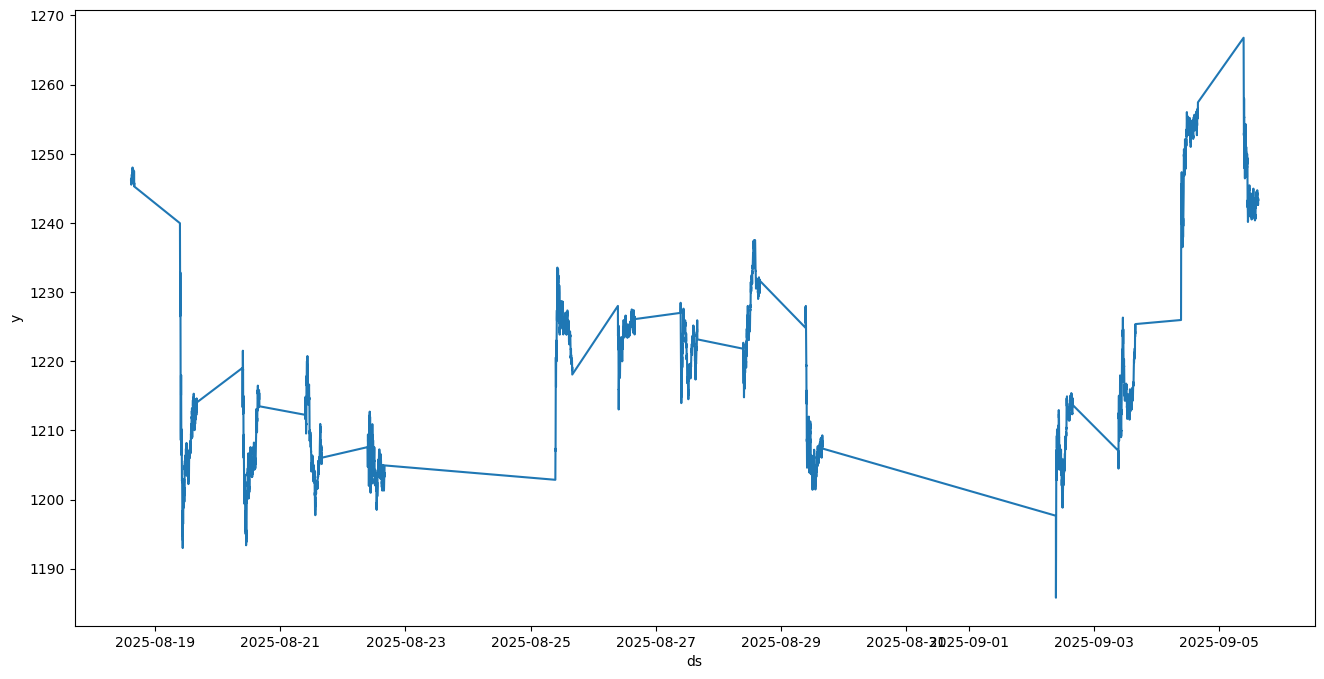

In [36]:
# Checking for the outlier in the target variable 
plt.figure(figsize=(16, 8))
sns.lineplot(data=stock_data, x='ds', y='y')
plt.show()

In [44]:
# Saving the loaded data to local 
import glob

stock_data.to_csv(os.path.join(PROCESSED_DATA_DIR, f"{datetime.now().strftime('%Y-%m-%d')}_cleaned_data.csv"), index=False)

keep_file = SETTINGS['data']['keep_days']
for file in glob.glob(os.path.join(PROCESSED_DATA_DIR,  "*.csv")):
    file_time= datetime.fromtimestamp(os.path.getmtime(file))
    if (datetime.now() - file_time).days >keep_file:
        os.remove(file)
        print(f"Deleted old file: {file}")